In [3]:
from bs4 import BeautifulSoup
import requests
import urllib
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

## Get all the links for the decisions
Submit a request form to the server since site is using SPA routing

In [4]:
apofaseis_search = "https://www.areiospagos.gr/nomologia/apofaseis.asp"

apofaseis_request = requests.get(apofaseis_search)
apofaseis_request.encoding = 'iso-8859-7'

apofaseis_search_soup = BeautifulSoup(apofaseis_request.text, "html.parser")

form = apofaseis_search_soup.find("form", {"name": "frmsearch"})

action_url = form.get("action")
action_url = urllib.parse.urljoin("https://www.areiospagos.gr/nomologia/", action_url)

print(action_url)

https://www.areiospagos.gr/nomologia/apofaseis_result.asp?S=1


In [5]:
method = form.get("method", "post").lower()

# this is the data submitted by the form when we filter for 2024 decisions
data = {
    "X_TMHMA": "6",
    "X_SUB_TMHMA": "1",
    "X_TELESTIS_number": "1", 
    "x_number": "",
    "X_TELESTIS_ETOS": "1",
    "x_ETOS": "2024",
    "submit_krit": "Αναζήτηση" 
}

# submit form
send_form = requests.post(action_url, data=data)
send_form.encoding = 'iso-8859-7'

# get result html
res = BeautifulSoup(send_form.text, "html.parser")

links = []
for link in res.find_all("a"):
    href = link.get("href")
    # ignore all links that are not Ποινικές or Πολιτικές αποφάσεις
    if "ΠΟΙΝΙΚΕΣ" in href or "ΠΟΛΙΤΙΚΕΣ" in href:
        links.append(href)

for link in links:
    print(link)

apofaseis_DISPLAY.asp?cd=RWKDTA2X1554EH8YXW0M7NFLRRV23P&apof=11_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=N1RABGMSWJWJ7DHP4GZ8JI6Q4TFTMD&apof=12_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=RSMY30KIH82MLOOC1VPLFAXXXSO0UO&apof=13_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=ZU5LE0TC6T0315OGAQ6IMDLESK4ST3&apof=14_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=RMR33L8SVVS7NNHF953HQAIZ6BH2BY&apof=31_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=ZMKMKEWUEMJDUCD7H9BL57XHERNGA1&apof=32_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=3PLUGVN70O3EYA1HCFVH441DER064B&apof=33_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=WRCLL8HRHRRPP149D93OA7BVARDXNC&apof=37_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=W6SJQ8Y4X3FVDSLXTVB05HVJ2G66P0&apof=38_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=ELNT5PH8GGM0QRC3WEG0TVGYIL8066&apof=39_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_DISPLAY.asp?cd=DW2MKWLR732NXRLNEDXGVFJC7OEA2C&apof=54_2024&info=ΠΟΛΙΤΙΚΕΣ -  Β1
apofaseis_

In [6]:
def get_decision(text):
    apofash_re_pattern = r"Απόφαση \d+ / 2024" # find patterns: Απόφαση {Αριθμός} / 2024
    apofash_re_matches = re.findall(apofash_re_pattern, text)

    if apofash_re_matches:
        return apofash_re_matches[0]
    else:
        return ""

In [7]:
def get_department(text):
    tmhma_re_pattern = r"\(((?:[Α-Ω]{1,2}\d*)|ΟΛΟΜΕΛΕΙΑ), (ΠΟΛΙΤΙΚΕΣ|ΠΟΙΝΙΚΕΣ)\)" # find patterns: ({Αριθμός Τμήματος}, {ΠΟΛΙΤΙΚΕΣ Ή ΠΟΙΝΙΚΕΣ}) 'Η ({ΟΛΟΜΕΛΕΙΑ}, {ΠΟΛΙΤΙΚΕΣ Ή ΠΟΙΝΙΚΕΣ})
    tmhma_re_matches = re.findall(tmhma_re_pattern, text)

    if tmhma_re_matches:
        tmhma_result = ""
        tup = ast.literal_eval(str(tmhma_re_matches[0]))
        if "ΟΛΟΜΕΛΕΙΑ" in tup[0]: # check if it is 'ΟΛΟΜΕΛΕΙΑ'
            tmhma_result = "ΣΕ ΠΛΗΡΗ ΟΛΟΜΕΛΕΙΑ"
        else:
            tmhma_result = tup[0] + "' " + tup[1].replace("ΕΣ", "Ο") + " TMHMA"
        return tmhma_result
    else:
        return ""

In [14]:
def get_judges(text):
    dikastes_re_pattern = r"(?:ΣΥΓΚΡΟΤΗΘΗΚΕ|Συγκροτήθηκε) από τους (.*?)Αρεοπαγίτες\." # find pattern: Συγκροτήθηκε από τους ... Αρεοπαγίτες.
    dikastes_re_match = re.search(dikastes_re_pattern, text, re.IGNORECASE)

    if dikastes_re_match:
        dikastes_result = "Συγκροτήθηκε από τους " + dikastes_re_match.group(1).strip()
    else:
        return ""
    
    parts_to_exclude = [
    "Συγκροτήθηκε από τους δικαστές, ",
    "Συγκροτήθηκε από τους Δικαστές, ",
    "Συγκροτήθηκε από τους Δικαστές:",
    "ΣΥΓΚΡΟΤΗΘΗΚΕ από τους Δικαστές:",
    "Συγκροτήθηκε από τους δικαστές:",
    "Συγκροτήθηκε από τους Δικαστές :",
    ", Αντιπρόεδρο του Αρείου Πάγου, ",
    "Αντιπροέδρο του Αρείου Πάγου",
    " και ",
    "Προεδρεύοντα Αρεοπαγίτη",
    "Προεδρεύουσα Αρεοπαγίτη",
    "Προεδερεύουσα Αρεοπαγίτη",
    "Προεδρεύοντα Αντιπρόεδρο",
    "Αντιπρόεδρο του ..."
    ]
    
    # remove all the parts we don't want in the final result
    for part in parts_to_exclude:
        if (part in dikastes_result):
            dikastes_result = dikastes_result.replace(part, ", ")

    # Remove parentheses and their content
    dikastes_result = re.sub(r"\([^)]*\)", ", ", dikastes_result)

    judges_names = []
    for j in [name.strip() for name in dikastes_result.split(",")]:
        if j != "":
            judges_names.append(j)

    return judges_names

In [9]:
def get_section(text, start_phrase, end_phrase, output_header="", start_phrase_variety=None):
    section_re_pattern = None
    if start_phrase_variety != None: # some times there are extra letters i.e. 'ΤΟ' and 'ΤΟΝ'
        section_re_pattern = re.escape(start_phrase[:start_phrase_variety[0]]) + rf"{start_phrase_variety[1]}?" + re.escape(start_phrase[start_phrase_variety[0]:]) + r"(.*?)?" + re.escape(end_phrase)
    else:
        section_re_pattern = re.escape(start_phrase) + r"(.*?)?" + re.escape(end_phrase) # find pattern: {start_phrase} ... {end_phrase}
    section_re_match = re.search(section_re_pattern, text, re.DOTALL)

    if section_re_match:
        section_result = output_header + "\n" + section_re_match.group(1).strip()
        return section_result
    else:
        return ""

In [10]:
def get_end_section(text, start_phrase, end_phrase):
    section_pattern = rf"{start_phrase}(.*?){end_phrase}" # again find pattern: {start_phrase} ... {end_phrase}
    section_match = re.search(section_pattern, text, re.DOTALL)

    if section_match:
        section_result = start_phrase + "\n" + section_match.group(1)
        return section_result
    else:
        return ""

In [11]:
def get_articles(text, start_phrases, article_keywords):
    start_pattern = "(?:" + "|".join(re.escape(phrase) for phrase in start_phrases) + ")" # account for all possible start phrases (i.e. "άρθρ", "άρθρου", ...)
    end_pattern = "(?:" + "|".join(re.escape(phrase) for phrase in article_keywords) + ")"# account for all possible end phrases (i.e. "ΠΚ", "ΚΠΔ", "ΑΚ", "ΚΠολΔ")
    negative_lookahead_pattern = "(?:(?!(?:" + "|".join(re.escape(phrase) for phrase in start_phrases) + ")).)"

    articles_pattern = rf"{start_pattern}{negative_lookahead_pattern}*?{end_pattern}"
    articles_matches = re.findall(articles_pattern, text)

    if articles_matches:
        return articles_matches
    else:
        return ""

In [15]:
url = "https://www.areiospagos.gr/nomologia/"

# create pandas dataframe
data = {
    'Απόφαση': [],
    'Τμήμα': [],
    'Δικαστές': [],
    'ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ': [],
    'ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ': [],
    'ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ': [],
    'Άρθρα': []
    }
df = pd.DataFrame(data)

# start collecting
for link in links:
    req = requests.get(url + link)
    req.encoding = 'iso-8859-7'
    soup = BeautifulSoup(req.text, "html.parser")

    try:
        html_frag = soup.find("font", face="Arial")

        decision = get_decision(html_frag.text)

        department = get_department(html_frag.text)

        judges = get_judges(html_frag.text)

        section_1 = get_section(html_frag.text, "Αρεοπαγίτες.", "ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ", output_header="ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ")
        section_2 = get_section(html_frag.text, "ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ", "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ", output_header="ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ", start_phrase_variety=(22, "Ν"))
        section_3 = get_end_section(html_frag.text, "ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ", "<< Επιστροφή")

        articles = ""
        if "ΠΟΙΝΙΚΕΣ" in link:
            articles = get_articles(html_frag.text, ["άρθρ", "αρθ"], ["ΠΚ", "ΚΠΔ"])
        elif "ΠΟΛΙΤΙΚΕΣ" in link:
            articles = get_articles(html_frag.text, ["άρθρ", "αρθ"], ["ΑΚ", "ΚΠολΔ"])

        # add new row to dataframe
        new_row_data = {
            'Απόφαση': str(decision),
            'Τμήμα': str(department),
            'Δικαστές': str(judges),
            'ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ': str(section_1),
            'ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ': str(section_2),
            'ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ': str(section_3),
            'Άρθρα': str(articles)
        }
        df.loc[len(df)] = new_row_data

    except:
        print("An error occured with the page.")

An error occured with the page.
An error occured with the page.
An error occured with the page.
An error occured with the page.
An error occured with the page.


In [16]:
display(df)

,Απόφαση,Τμήμα,Δικαστές,ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ,Άρθρα
0,Απόφαση 11 / 2024,Β1' ΠΟΛΙΤΙΚΟ TMHMA,"['Λουκά Μόρφη', 'Δήμητρα Ζώη', 'Ιωάννα Μαργέλλ...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΣυνήλθε σε δημ...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΑπό τη διάταξη τ...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \nΑπορρίπτει την από ...,"['άρθρα 552, 553, 556, 558, 564 παρ. 3, 566 πα..."
1,Απόφαση 12 / 2024,Β1' ΠΟΛΙΤΙΚΟ TMHMA,"['Λουκά Μόρφη', 'Δήμητρα Ζώη', 'Ιωάννα Μαργέλλ...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΣυνήλθε σε δημ...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΥπόκειται προς κ...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \nΑπορρίπτει την από ...,"['άρθρο 564 παρ. 1 ΚΠολΔ', 'άρθρα 552, 553, 55..."
2,Απόφαση 13 / 2024,Β1' ΠΟΛΙΤΙΚΟ TMHMA,"['Ιωάννα Μαργέλλου-Μπουλταδάκη', 'Ελένη Χροναί...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΣυνήλθε σε δημ...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΜε την από 16 Ια...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \nΑπορρίπτει την από ...,"['άρθρων 648 παρ. 1, 681 ΑΚ', 'άρθρου 38 ΕισΝΑ..."
3,Απόφαση 14 / 2024,Β1' ΠΟΛΙΤΙΚΟ TMHMA,"['Ιωάννα Μαργέλλου-Μπουλταδάκη', 'Ελένη Χροναί...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΣυνήλθε σε δημ...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΜε την από 2 Νοε...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \nΑπορρίπτει την από ...,"['άρθρο 656 ΑΚ', 'άρθρου 559 αριθ. 1 εδ. α του..."
4,Απόφαση 31 / 2024,Β1' ΠΟΛΙΤΙΚΟ TMHMA,"['Δήμητρα Ζώη', 'Αριστείδη Βαγγελάτο', 'Ελπίδα...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΣυνήλθε σε δημ...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΜε τη διάταξη το...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n Συνεκδικάζει την από ...,"['άρθρου 576 παρ. 1 του ΚΠολΔ', 'άρθρο 143 παρ..."
...,...,...,...,...,...,...,...
2392,Απόφαση 1096 / 2024,,"['Απόστολο Φωτόπουλο', 'Ευαγγελία Στεργίου', '...",,,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \n\nΑνακαλεί την υπ' ...,"[""άρθρο 135 στοιχ. ε' ΚΠΔ"", ""άρθρου 136§ 1 στο..."
2393,Απόφαση 1157 / 2024,,"['Απόστολο Φωτόπουλο', '- Εισηγητή', 'Ευαγγελί...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΣυνήλθε σε δημ...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΜε την από 14-6-...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \n\nΑναιρεί στο σύνολ...,"['άρθρου 84 παράγραφος 2ε του ΠΚ', 'άρθρο 224 ..."
2394,Απόφαση 1158 / 2024,,"['Απόστολο Φωτόπουλο', '- Εισηγητή', 'Ευαγγελί...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΜε την παρουσί...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΣύμφωνα με το άρ...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \n\nΠροτείνω: \n\nΑ) ...,"['άρθρα 30 παρ. 2,4,138 παρ. 1 β, 525 παρ. 1 π..."
2395,Απόφαση 1160 / 2024,,"['Απόστολο Φωτόπουλο', 'Ευαγγελία Στέργιου', '...",ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ\nΣυνήλθε σε δημ...,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΗ υπό κρίση από ...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \n\nΑΝΑΙΡΕΙ την υπ`αρ...,"[""άρθρ. 462 περ. β', 464, 505παρ 2α ΚΠΔ"", 'άρθ..."


In [17]:
df.to_csv('results.csv', index=False, encoding='utf-8')
print("DataFrame saved to results.csv")

DataFrame saved to results.csv


### Load csv again
To make sure it is written correctly

In [18]:
df = pd.read_csv("results.csv")
test_row = df[df['Απόφαση'] == 'Απόφαση 355 / 2024']
test_row

,Απόφαση,Τμήμα,Δικαστές,ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ,Άρθρα
248,Απόφαση 355 / 2024,Β2' ΠΟΛΙΤΙΚΟ TMHMA,NaN,NaN,ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟΝ ΝΟΜΟ\nΜε την κρινόμενη...,ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ\n \nΑναιρεί την με αριθ...,['άρθρα 51 και 53 ν. 4387/2016 (Α 85) ήδη ΝΠΔΔ...


### Bar Plot for Classes

In [19]:
df['Τμήμα'].value_counts()

Τμήμα
Α2' ΠΟΛΙΤΙΚΟ TMHMA    333
Δ' ΠΟΛΙΤΙΚΟ TMHMA     291
Γ' ΠΟΛΙΤΙΚΟ TMHMA     252
ΣΤ' ΠΟΙΝΙΚΟ TMHMA     240
Ζ' ΠΟΙΝΙΚΟ TMHMA      236
Β2' ΠΟΛΙΤΙΚΟ TMHMA    220
Β1' ΠΟΛΙΤΙΚΟ TMHMA    206
Ε' ΠΟΙΝΙΚΟ TMHMA      205
Α3' ΠΟΛΙΤΙΚΟ TMHMA    202
Α1' ΠΟΛΙΤΙΚΟ TMHMA    167
ΣΕ ΠΛΗΡΗ ΟΛΟΜΕΛΕΙΑ      8
Name: count, dtype: int64

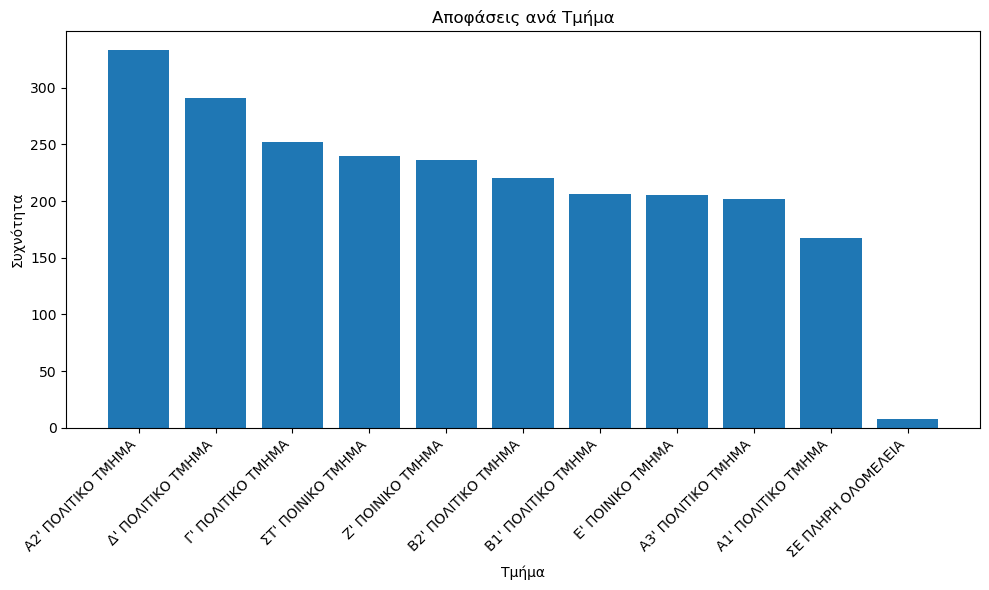

In [20]:
plt.figure(figsize=(10, 6))
plt.bar(df['Τμήμα'].value_counts().index.tolist(), 
        df['Τμήμα'].value_counts().values.tolist())
plt.xlabel("Τμήμα")
plt.ylabel("Συχνότητα")
plt.title("Αποφάσεις ανά Τμήμα")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Bar plot for Judges

In [21]:
from collections import Counter

all_judges = []

# create a list with all the judges for each decision
for judges_list in df['Δικαστές']:
    if isinstance(judges_list, str):
        row_judges = (judges_list[1:-1]).replace("'", "").split(", ")
        all_judges.extend(row_judges)

# count the occurances of each judge
judge_counts = Counter(all_judges)
judge_counts = pd.Series(judge_counts).sort_values(ascending=False)
print(judge_counts)

Παναγιώτη Βενιζελέα                          298
Αλεξάνδρα Αποστολάκη                         267
Σωκράτη Πλαστήρα                             264
Θεόδωρο Κανελλόπουλο                         263
Κλεόβουλο - Δημήτριο Κοκκορό                 246
                                            ... 
Παναγιώτα Πασσίση -Εισηγήτρια                  1
Στέφανο-Σπυρίδων Πανταζόπουλο-Εισηγητή         1
Στέφανο-Σπυρίδωνα Πανταζόπουλο - Εισηγητή      1
Χρήστο Κατσιάνη -Εισηγητή                      1
Δέσποινα Βασιλοδημητράκη-Εισηγήτρια            1
Length: 363, dtype: int64


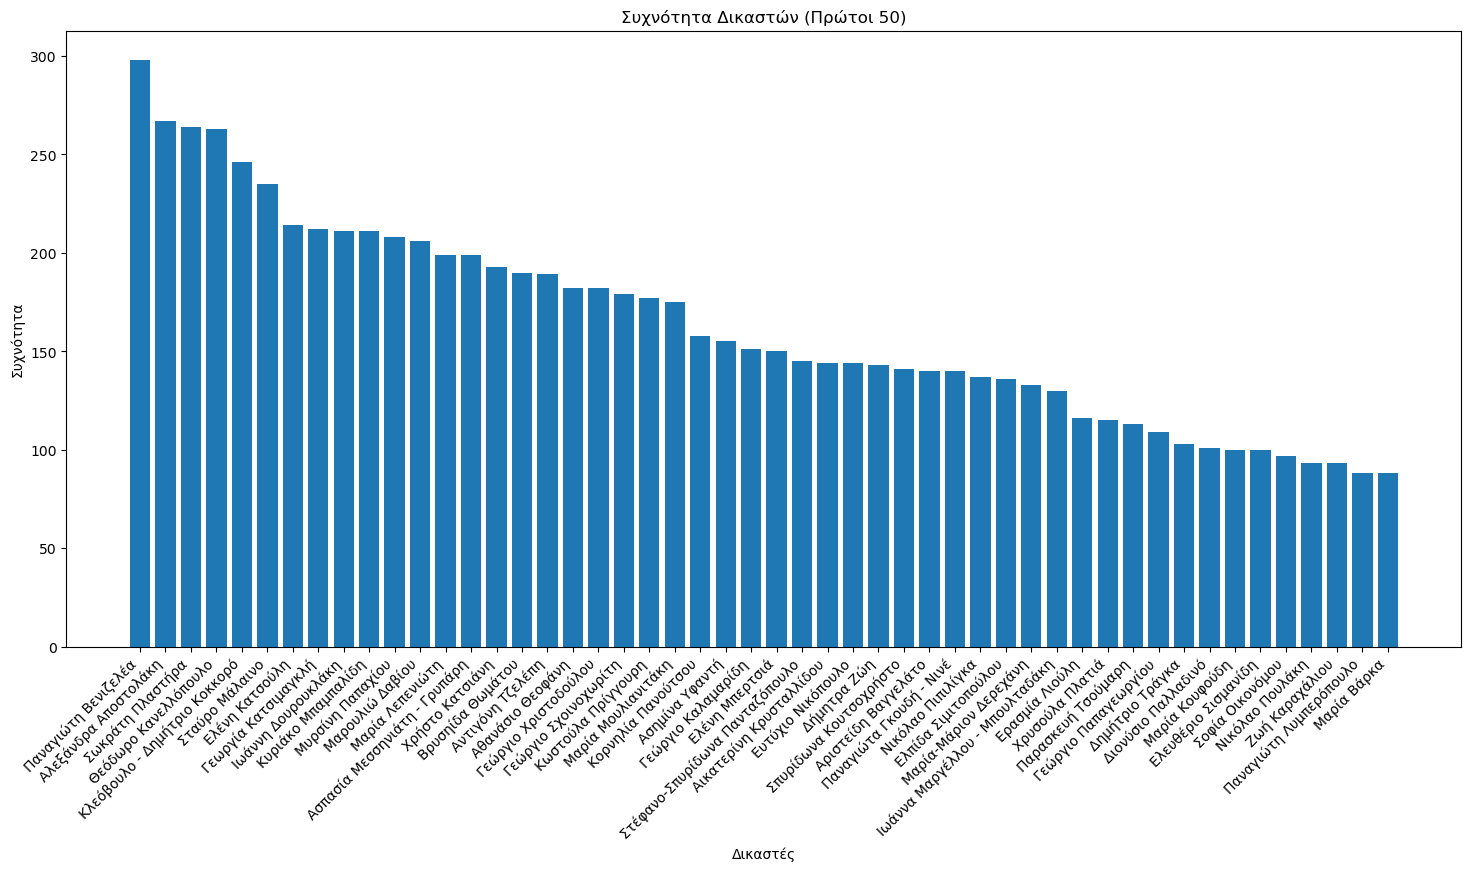

In [22]:
plt.figure(figsize=(18, 8))
plt.bar(judge_counts.index.tolist()[:50], 
        judge_counts.values.tolist()[:50])
plt.xlabel("Δικαστές")
plt.ylabel("Συχνότητα")
plt.title("Συχνότητα Δικαστών (Πρώτοι 50)")
plt.xticks(rotation=45, ha='right')
plt.show()

### String Lengths for Sections

In [23]:
def group_numbers_by_spans(numbers, spans):
    grouped_numbers = {end: [] for _, end in spans}
    other_numbers = []

    for number in numbers:
        grouped = False
        for (key, val) in grouped_numbers.items():
            if number < key:
                val.append(number)
                grouped = True
                break
        if not grouped:
            other_numbers.append(number)

    if other_numbers:
        grouped_numbers["Other"] = other_numbers

    return grouped_numbers

##### ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ

In [24]:
sections_1_lens = []

for section in df['ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ']:
    if isinstance(section, str):
        sections_1_lens.append(len(section))

spans = [(0, 2000), (2000, 5000), (5000, 10000), (10000, 20000), (20000, 100000)]

sections_1_groups = group_numbers_by_spans(sections_1_lens, spans)

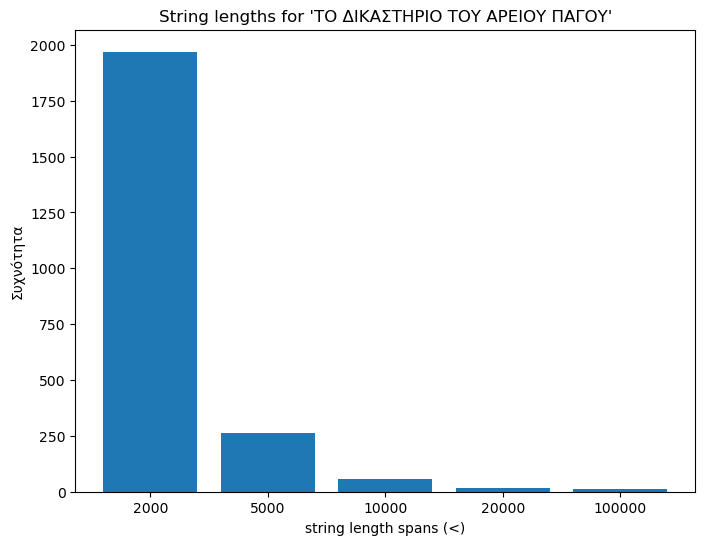

In [25]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(list(sections_1_groups.keys()))), [len(val) for (_, val) in sections_1_groups.items()])
plt.xlabel("string length spans (<)")
plt.ylabel("Συχνότητα")
plt.title("String lengths for 'ΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ΠΑΓΟΥ'")
plt.xticks(range(len(list(sections_1_groups.keys()))), list(sections_1_groups.keys()))
plt.show()

##### ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ

In [26]:
sections_2_lens = []

for section in df['ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ']:
    if isinstance(section, str):
        sections_2_lens.append(len(section))

spans = [(0, 2000), (2000, 5000), (5000, 10000), (10000, 20000), (20000, 100000)]

sections_2_groups = group_numbers_by_spans(sections_2_lens, spans)

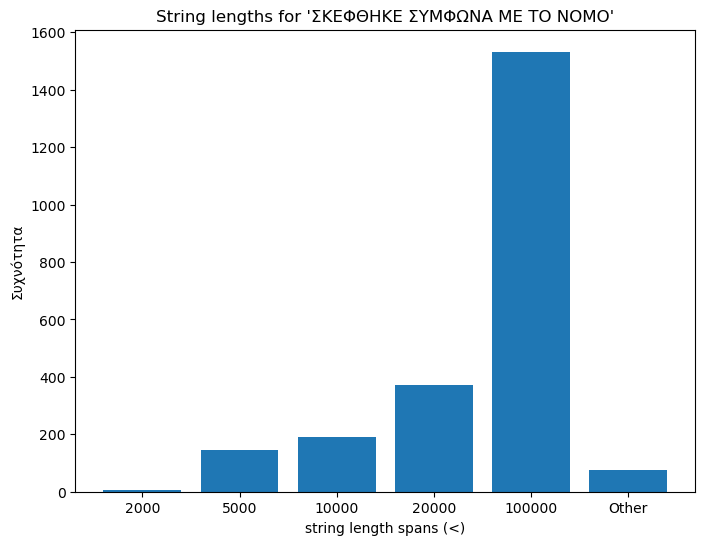

In [27]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(list(sections_2_groups.keys()))), [len(val) for (_, val) in sections_2_groups.items()])
plt.xlabel("string length spans (<)")
plt.ylabel("Συχνότητα")
plt.title("String lengths for 'ΣΚΕΦΘΗΚΕ ΣΥΜΦΩΝΑ ΜΕ ΤΟ ΝΟΜΟ'")
plt.xticks(range(len(list(sections_2_groups.keys()))), list(sections_2_groups.keys()))
plt.show()

##### ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ

In [28]:
sections_3_lens = []

for section in df['ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ']:
    if isinstance(section, str):
        sections_3_lens.append(len(section))

spans = [(0, 2000), (2000, 5000), (5000, 10000), (10000, 20000), (20000, 100000)]

sections_3_groups = group_numbers_by_spans(sections_3_lens, spans)

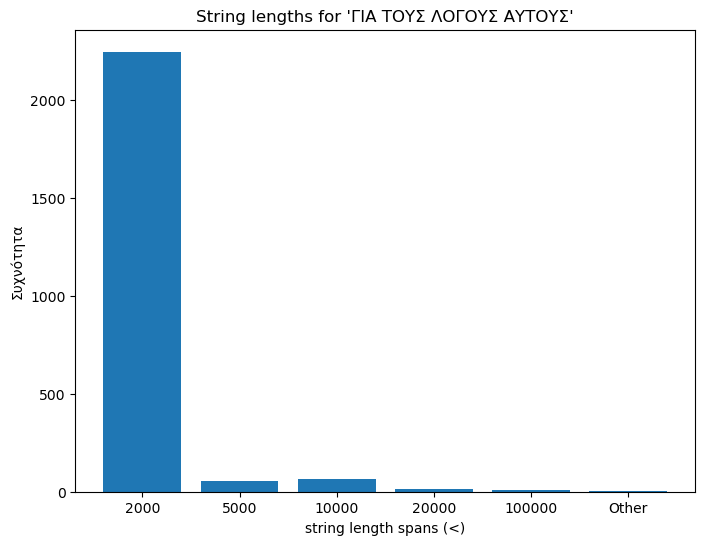

In [29]:
plt.figure(figsize=(8, 6))
plt.bar(range(len(list(sections_3_groups.keys()))), [len(val) for (_, val) in sections_3_groups.items()])
plt.xlabel("string length spans (<)")
plt.ylabel("Συχνότητα")
plt.title("String lengths for 'ΓΙΑ ΤΟΥΣ ΛΟΓΟΥΣ ΑΥΤΟΥΣ'")
plt.xticks(range(len(list(sections_3_groups.keys()))), list(sections_3_groups.keys()))
plt.show()

### Article Stats

In [31]:
articles = []

for article in df['Άρθρα']:
    if isinstance(article, str):
        list_article = (article[1:-1]).replace("'", "").split(", ")
        articles.extend(list_article)

articles_count = {'PK': [],
                  'KPD': [],
                  'AK': [],
                  'KPolD': []
                  }

for article in articles:
    if 'ΠΚ' in article:
        articles_count['PK'].append(article)
    elif 'ΚΠΔ' in article:
        articles_count['KPD'].append(article)
    elif 'ΑΚ' in article:
        articles_count['AK'].append(article)
    else:
        articles_count['KPolD'].append(article)

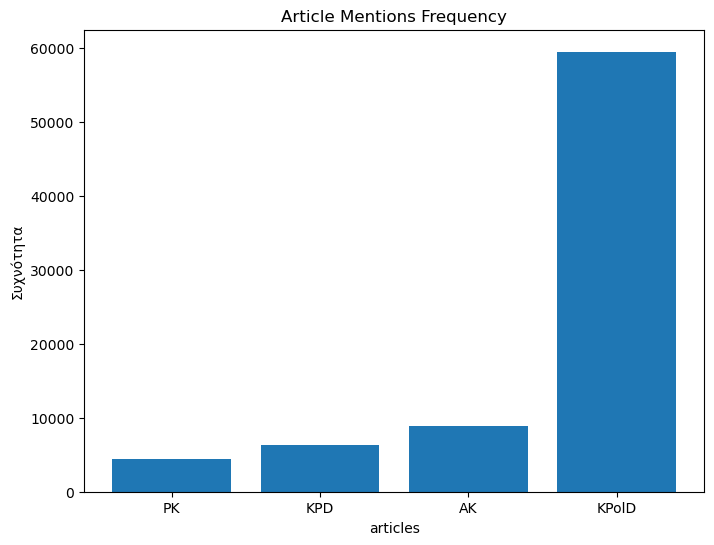

In [32]:
plt.figure(figsize=(8, 6))
plt.bar([key for (key, _) in articles_count.items()], [len(val) for (_, val) in articles_count.items()])
plt.xlabel("articles")
plt.ylabel("Συχνότητα")
plt.title("Article Mentions Frequency")
plt.show()